FEATURE EXTRACTOR

In [17]:
import cv2
import pandas as pd
import numpy as np
import os
from skimage.feature import local_binary_pattern, hog
from tqdm import tqdm # A progress bar! pip install tqdm

# --- CONFIGURATION ---
PREPROCESSED_DIR = "preprocessed_images"
LABELS_FILE = "label_results_merged (1).csv" # Your manually created labels
OUTPUT_DATASET = "training_dataset_baseline.csv" # The file this script will create

GRID_ROWS = 8
GRID_COLS = 8
CELL_HEIGHT = 600 // GRID_ROWS # 75 pixels
CELL_WIDTH = 800 // GRID_COLS  # 100 pixels

# LBP (Local Binary Patterns) configuration
LBP_POINTS = 24 # Number of points to check around a pixel
LBP_RADIUS = 3  # Radius of the circle

# --- Color Histogram configuration ---
HIST_BINS = [4, 4, 4] # 4 bins for B, 4 for G, 4 for R = 4*4*4=64 features

# --- HOG Configuration ---
HOG_ORIENTATIONS = 8
HOG_PIXELS_PER_CELL = (25, 25) # 100x75 cell -> (100/25)x(75/25) = 4x3 grid of cells
HOG_CELLS_PER_BLOCK = (1, 1)   # No block normalization
# Total HOG Features = 4 * 3 * 1 * 1 * 8 = 96 features
N_HOG_FEATURES = (CELL_WIDTH // HOG_PIXELS_PER_CELL[0]) * \
                 (CELL_HEIGHT // HOG_PIXELS_PER_CELL[1]) * \
                 (HOG_CELLS_PER_BLOCK[0] * HOG_CELLS_PER_BLOCK[1]) * \
                 HOG_ORIENTATIONS

def extract_features_for_cell(cell):
    """
    This function takes one 100x75 cell (a BGR image) and returns
    a 1D numpy array of its calculated baseline features.
    """
    features = []

    # --- 1. Color Features (Average & Std Dev BGR) ---
    # We now capture both mean and standard deviation
    (means, stds) = cv2.meanStdDev(cell)
    features.extend(means.flatten()) # Add B_mean, G_mean, R_mean
    features.extend(stds.flatten()) # Add B_std, G_std, R_std

    # --- 2. Grayscale & Edge Features ---
    gray_cell = cv2.cvtColor(cell, cv2.COLOR_BGR2GRAY)

    # Apply CLAHE to enhance local contrast and fight camouflage
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4, 4))
    gray_cell = clahe.apply(gray_cell)
    
    # Canny Edge Density
    # We still need grayscale stats to find good Canny thresholds
    (gray_mean, gray_std) = cv2.meanStdDev(gray_cell)
    sigma = gray_std[0][0]
    v = gray_mean[0][0]
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    
    edges = cv2.Canny(gray_cell, lower, upper)
    edge_density = np.sum(edges > 0) / (CELL_WIDTH * CELL_HEIGHT)
    features.append(edge_density)

    # --- 3. Texture Features (LBP) ---
    # We use the 'uniform' method, which is robust and limits features.
    # It results in (LBP_POINTS + 2) features.
    lbp = local_binary_pattern(gray_cell, LBP_POINTS, LBP_RADIUS, method="uniform")
    
    # Create a normalized histogram of the LBP results
    (hist, _) = np.histogram(lbp.ravel(),
                             bins=np.arange(0, LBP_POINTS + 3),
                             range=(0, LBP_POINTS + 2))
    
    # Normalize histogram to be a probability distribution
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6) # Add epsilon to avoid division by zero
    
    features.extend(hist)

    # --- 4. 3D Color Histogram ---
    # Calculate a 3D histogram for B, G, R channels
    hist_3d = cv2.calcHist([cell], [0, 1, 2], None, HIST_BINS,
                           [0, 256, 0, 256, 0, 256])
    
    # Normalize the histogram
    cv2.normalize(hist_3d, hist_3d, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    
    #Flatten the 3D histogram into a 1D vector
    features.extend(hist_3d.flatten())

    # --- 5. HOG (Histogram of Oriented Gradients) Features ---
    hog_features = hog(gray_cell, orientations=HOG_ORIENTATIONS,
                       pixels_per_cell=HOG_PIXELS_PER_CELL,
                       cells_per_block=HOG_CELLS_PER_BLOCK,
                       visualize=False, block_norm='L1')
    features.extend(hog_features.flatten())
    
    return np.array(features)

# --- MAIN SCRIPT ---
if __name__ == "__main__":
    print("Starting feature extraction...")
    
    # Load the labels
    if not os.path.exists(LABELS_FILE):
        print(f"Error: Labels file not found at {LABELS_FILE}")
        exit()
    labels_df = pd.read_csv(LABELS_FILE)
    labels_df.rename(columns={"filename": "image_name"}, inplace=True)
    new_columns = {"cell_" + str(i): f"c{i+1:02d}" for i in range(64)}
    labels_df.rename(columns=new_columns, inplace=True)

    
    all_features = []
    all_labels = []
    all_images = []
    cell_indices = []

    # Use tqdm for a progress bar. Iterating rows is like iterating images.
    for index, row in tqdm(labels_df.iterrows(), total=labels_df.shape[0], desc="Processing Images"):
        image_name = row['image_name']
        image_path = os.path.join(PREPROCESSED_DIR, image_name)
        
        image = cv2.imread(image_path)
        if image is None:
            print(f"Warning: Could not load image {image_name}. Skipping.")
            continue
        l = [image_name]*GRID_ROWS*GRID_COLS
        all_images+=l
            
        # Iterate over the 8x8 grid
        cell_index = 1
        for i in range(GRID_ROWS):
            for j in range(GRID_COLS):
                # Calculate coordinates for the cell
                y1, y2 = i * CELL_HEIGHT, (i + 1) * CELL_HEIGHT
                x1, x2 = j * CELL_WIDTH, (j + 1) * CELL_WIDTH
                
                # Extract the 100x75 cell
                cell = image[y1:y2, x1:x2]
                
                # Get the label for this cell from the CSV
                # Column name is 'c01', 'c02', ... 'c64'
                cell_label_col = f'c{(i * GRID_COLS + j + 1):02d}'
                label = row[cell_label_col]
                
                # --- This is the core step ---
                features = extract_features_for_cell(cell)
                
                all_features.append(features)
                all_labels.append(label)
                cell_indices.append(cell_index)
                cell_index+=1

    print("\nFeature extraction complete. Assembling final dataset...")

    # Create a list of feature names for the CSV header
    # This list is now updated to match our baseline features
    feature_names = ['B_mean', 'G_mean', 'R_mean', 'B_std', 'G_std', 'R_std', 'Edge_density']
    # Add LBP histogram feature names
    feature_names += [f'LBP_bin_{k}' for k in range(LBP_POINTS + 2)]
    # Add Color Histogram names (e.g., 'hist_B0_G0_R0')
    hist_feature_names = [f'hist_B{b}_G{g}_R{r}' 
                          for b in range(HIST_BINS[0]) 
                          for g in range(HIST_BINS[1]) 
                          for r in range(HIST_BINS[2])]
    feature_names.extend(hist_feature_names)
    # Add HOG feature names
    hog_feature_names = [f'hog_{i}' for i in range(N_HOG_FEATURES)]
    feature_names.extend(hog_feature_names)

    # Create the final DataFrame
    X = np.array(all_features)
    y = np.array(all_labels)
    image_names = np.array(all_images)
    cell_indices = np.array(cell_indices)

    dataset_df = pd.DataFrame(X, columns=feature_names)
    dataset_df['label'] = y
    dataset_df['image_name'] = image_names
    dataset_df['cell_index'] = cell_indices
    
    # Save to CSV
    dataset_df.to_csv(OUTPUT_DATASET, index=False)
    
    print(f"Success! Training dataset saved to {OUTPUT_DATASET}")
    print(f"Total rows (cells): {len(dataset_df)}")
    print(f"Total features: {len(feature_names)}")

Starting feature extraction...


Processing Images:   1%|▋                                                                         | 4/465 [00:01<02:43,  2.82it/s]

Processing Images:  11%|████████▏                                                                | 52/465 [00:16<02:09,  3.19it/s]

Processing Images: 100%|████████████████████████████████████████████████████████████████████████| 465/465 [01:46<00:00,  4.37it/s]



Feature extraction complete. Assembling final dataset...
Success! Training dataset saved to training_dataset_baseline.csv
Total rows (cells): 17728
Total features: 193


In [18]:
labels = []
for _, row in labels_df.iterrows():  
    for i in range(1,64):
        label = row[i]
        labels.append(label)
count_zeros = labels.count(0)
count_ones = labels.count(1)
print(f"Count of 0s: {count_zeros}")
print(f"Count of 1s: {count_ones}")

C:\Users\mithr\AppData\Local\Temp\ipykernel_7472\4124604336.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[i]


Count of 0s: 20926
Count of 1s: 8369


In [3]:
"""import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- CONFIGURATION ---
DATASET_FILE = "training_dataset_baseline.csv"
MODEL_OUTPUT_FILE = "wildlife_model.pkl" # The final, saved model
PLOT_OUTPUT_FILE = "confusion_matrix.png" # The evaluation plot

# --- MAIN SCRIPT ---
if __name__ == "__main__":
    
    # --- 1. Load Data ---
    print(f"Loading dataset from {DATASET_FILE}...")
    if not os.path.exists(DATASET_FILE):
        print(f"Error: Dataset file not found at {DATASET_FILE}")
        print("Please run feature_extractor.py first.")
        exit()
        
    df = pd.read_csv(DATASET_FILE)

    # Simple data cleaning: Fill any potential NaN values with 0
    # (This can happen with LBP on all-black cells, etc.)
    df.fillna(0, inplace=True)
    
    # --- 2. Split Data (Features & Labels) ---
    print("Splitting data into training and test sets...")
    
    X = df.drop("label", axis=1) # All columns EXCEPT 'label'
    y = df["label"]             # Just the 'label' column

    # Check for class imbalance (important for your report)
    print("\nClass Distribution:")
    print(y.value_counts(normalize=True))
    
    # Split the data. 
    # test_size=0.3 means 30% for testing, 70% for training.
    # stratify=y is CRITICAL: it ensures your train and test sets have
    # the same percentage of 0s and 1s as the full dataset.
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.3, 
                                                        random_state=42, 
                                                        stratify=y)
    
    print(f"\nTraining set size: {len(X_train)} cells")
    print(f"Test set size: {len(X_test)} cells")

    # --- 3. Train Baseline Model ---
    print("\nTraining baseline RandomForestClassifier...")
    
    # n_estimators=100 is a good default (100 "trees" in the forest)
    # n_jobs=-1 uses all your CPU cores to speed up training
    model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    
    # This is the step that does the actual learning
    model.fit(X_train, y_train)
    
    print("Model training complete.")

    # --- 4. Evaluate Model ---
    print("\nEvaluating model on the test set...")
    
    # Get predictions for the test data
    y_pred = model.predict(X_test)
    
    # Print a full report
    print("\n--- Classification Report ---")
    print(classification_report(y_test, y_pred, target_names=["No Wildlife (0)", "Wildlife (1)"]))
    
    # Generate and plot a confusion matrix
    print("\n--- Confusion Matrix ---")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    
    # Create a heatmap plot of the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=["Predicted 0", "Predicted 1"], 
                yticklabels=["Actual 0", "Actual 1"])
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.savefig(PLOT_OUTPUT_FILE)
    print(f"\nConfusion matrix plot saved to {PLOT_OUTPUT_FILE}")

    # --- 5. Save the Final Model ---
    print(f"\nSaving trained model to {MODEL_OUTPUT_FILE}...")
    
    # Use pickle to save the model to a file
    with open(MODEL_OUTPUT_FILE, "wb") as f:
        pickle.dump(model, f)
        
    print("\nBaseline model pipeline complete. Model is saved and ready for prediction.")"""


'import pandas as pd\nimport pickle\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.ensemble import RandomForestClassifier\nfrom sklearn.metrics import classification_report, confusion_matrix\nimport matplotlib.pyplot as plt\nimport seaborn as sns\nimport os\n\n# --- CONFIGURATION ---\nDATASET_FILE = "training_dataset_baseline.csv"\nMODEL_OUTPUT_FILE = "wildlife_model.pkl" # The final, saved model\nPLOT_OUTPUT_FILE = "confusion_matrix.png" # The evaluation plot\n\n# --- MAIN SCRIPT ---\nif __name__ == "__main__":\n\n    # --- 1. Load Data ---\n    print(f"Loading dataset from {DATASET_FILE}...")\n    if not os.path.exists(DATASET_FILE):\n        print(f"Error: Dataset file not found at {DATASET_FILE}")\n        print("Please run feature_extractor.py first.")\n        exit()\n\n    df = pd.read_csv(DATASET_FILE)\n\n    # Simple data cleaning: Fill any potential NaN values with 0\n    # (This can happen with LBP on all-black cells, etc.)\n    df.fillna(0, inplace=True

RANDOM FOREST

Loading dataset from training_dataset_baseline.csv...

Detected 193 feature columns.

Class Distribution:
label
0    0.715196
1    0.284804
Name: proportion, dtype: float64

Training size: 12409
Test size: 5319

Training Random Forest model...

--- Classification Report ---
              precision    recall  f1-score   support

 No Wildlife       0.82      0.95      0.88      3804
    Wildlife       0.80      0.46      0.58      1515

    accuracy                           0.81      5319
   macro avg       0.81      0.71      0.73      5319
weighted avg       0.81      0.81      0.79      5319


--- Confusion Matrix ---
[[3629  175]
 [ 821  694]]
Confusion matrix plot saved to confusion_matrix.png

Model saved to wildlife_model_rf.pkl
Training pipeline complete.


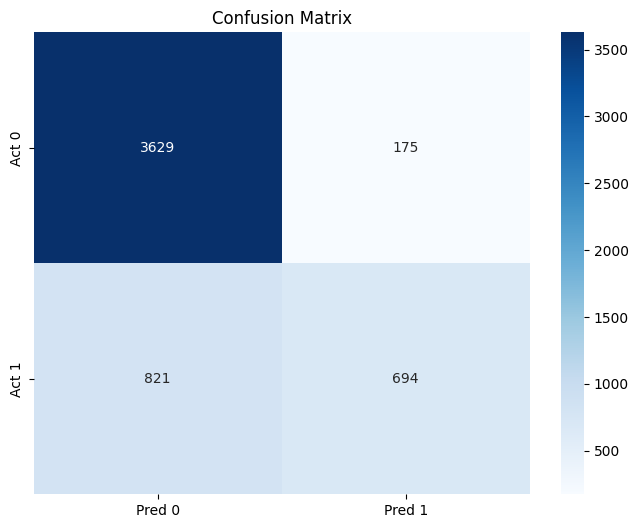

In [19]:
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- CONFIGURATION ---
DATASET_FILE = "training_dataset_baseline.csv"
MODEL_OUTPUT_FILE = "wildlife_model_rf.pkl"
PLOT_OUTPUT_FILE = "confusion_matrix.png"

if __name__ == "__main__":
    print(f"Loading dataset from {DATASET_FILE}...")
    if not os.path.exists(DATASET_FILE):
        print(f"Error: Dataset file not found at {DATASET_FILE}")
        exit()

    df = pd.read_csv(DATASET_FILE)
    df.fillna(0, inplace=True)  # Safety

    # --- Identify label column ---
    if "label" not in df.columns:
        raise ValueError("ERROR: The dataset must include a 'label' column!")

    label_col = "label"
    feature_cols = [col for col in df.columns if col not in [label_col, "image_name", "cell_index"]]

    print(f"\nDetected {len(feature_cols)} feature columns.")

    X = df[feature_cols]
    y = df[label_col]

    print("\nClass Distribution:")
    print(y.value_counts(normalize=True))

    # --- Train-test Split ---
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    print(f"\nTraining size: {len(X_train)}")
    print(f"Test size: {len(X_test)}")

    # --- Model Training ---
    print("\nTraining Random Forest model...")
    model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')
    model.fit(X_train, y_train)

    # --- Evaluation ---
    y_pred = model.predict(X_test)

    print("\n--- Classification Report ---")
    print(classification_report(y_test, y_pred, target_names=["No Wildlife", "Wildlife"]))

    cm = confusion_matrix(y_test, y_pred)
    print("\n--- Confusion Matrix ---")
    print(cm)

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Pred 0", "Pred 1"],
                yticklabels=["Act 0", "Act 1"])
    plt.title("Confusion Matrix")
    plt.savefig(PLOT_OUTPUT_FILE)
    print(f"Confusion matrix plot saved to {PLOT_OUTPUT_FILE}")

    # --- Save Model ---
    with open(MODEL_OUTPUT_FILE, "wb") as f:
        pickle.dump(model, f)

    print(f"\nModel saved to {MODEL_OUTPUT_FILE}")
    print("Training pipeline complete.")


In [20]:
import pandas as pd
import numpy as np
import pickle
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from tqdm import tqdm

# --- Import All the Models ---
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# --- CONFIGURATION ---
DATASET_FILE = "training_dataset_baseline.csv"

# --- 1. Load Data ---
print(f"Loading dataset from {DATASET_FILE}...")
df = pd.read_csv(DATASET_FILE)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# --- Identify label column ---
if "label" not in df.columns:
    raise ValueError("ERROR: The dataset must include a 'label' column!")

label_col = "label"
feature_cols = [col for col in df.columns if col not in ['image_name', 'cell_index', 'label']]

print(f"\nDetected {len(feature_cols)} feature columns.")

X = df[feature_cols]
y = df[label_col]

print("\nClass Distribution:")
print(y.value_counts(normalize=True))

# --- Train-test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training on {len(X_train)} samples, testing on {len(X_test)} samples.")

# --- 3. Create Scaled Data (CRITICAL STEP) ---
print("\nScaling data for parametric/non-parametric models...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Data scaling complete.")

# --- 4. Handle Class Imbalance (for XGBoost) ---
count_0 = y_train.value_counts()[0]
count_1 = y_train.value_counts()[1]
scale_pos_weight = count_0 / count_1
print(f"Imbalance ratio (0s/1s): {scale_pos_weight:.2f}")

# --- 5. Define Models ---
# Note: "Linear Regression" and "SVR" are for regression.
# Their classification counterparts are "LogisticRegression" and "SVC".
models = {
    "LogisticRegression (Parametric)": LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    
    "MLPClassifier (Neural Net)": MLPClassifier(hidden_layer_sizes=(100, 50), # 2 hidden layers
                                                max_iter=300, 
                                                random_state=42, 
                                                early_stopping=True),
                                                
    "XGBoost (Tree-based)": XGBClassifier(scale_pos_weight=scale_pos_weight, 
                                          random_state=42, 
                                          n_jobs=-1,
                                          eval_metric='logloss'),

    "Random Forest (Tree-based)": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced'),

    # --- WARNING: SLOW MODELS ---
    # The models below (KNN, SVC) are EXTREMELY slow on large,
    # high-dimensional data. Run them at your own risk.
    # I have commented them out so you don't accidentally run them.
    # ----------------------------------------------------
    
    "KNeighborsClassifier (Non-Parametric)": KNeighborsClassifier(n_neighbors=7, n_jobs=-1),
    
    "SVC (Parametric)": SVC(class_weight='balanced', random_state=42)
}

# Define which models need scaled data
models_that_need_scaling = ["LogisticRegression (Parametric)", 
                            "MLPClassifier (Neural Net)", 
                            "KNeighborsClassifier (Non-Parametric)", 
                            "SVC (Parametric)"]

# --- 6. Train and Evaluate ---
results = []
print("\n--- Starting Model Comparison ---")

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    start_time = time.time()
    
    # Choose the correct dataset (scaled or unscaled)
    if model_name in models_that_need_scaling:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        # Tree models (XGBoost, RandomForest) use unscaled data
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
    end_time = time.time()
    
    # Get the classification report
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    
    # Extract scores for the "Wildlife (1)" class
    precision = report['1']['precision']
    recall = report['1']['recall']
    f1_score = report['1']['f1-score']
    
    results.append({
        "Model": model_name,
        "Precision (for 1)": precision,
        "Recall (for 1)": recall,
        "F1-Score (for 1)": f1_score,
        "Train Time (sec)": end_time - start_time
    })

# --- 7. Print Final Comparison Table ---
print("\n--- Final Model Comparison Results ---")
results_df = pd.DataFrame(results).sort_values(by="F1-Score (for 1)", ascending=False)
results_df = results_df.set_index("Model")
print(results_df)

# Save results to a file for your presentation
results_df.to_csv("model_comparison_report.csv")
print("\nComparison report saved to model_comparison_report.csv")

Loading dataset from training_dataset_baseline.csv...

Detected 193 feature columns.

Class Distribution:
label
0    0.715196
1    0.284804
Name: proportion, dtype: float64
Training on 12409 samples, testing on 5319 samples.

Scaling data for parametric/non-parametric models...
Data scaling complete.
Imbalance ratio (0s/1s): 2.51

--- Starting Model Comparison ---

Training LogisticRegression (Parametric)...

Training MLPClassifier (Neural Net)...

Training XGBoost (Tree-based)...

Training Random Forest (Tree-based)...

Training KNeighborsClassifier (Non-Parametric)...

Training SVC (Parametric)...

--- Final Model Comparison Results ---
                                       Precision (for 1)  Recall (for 1)  \
Model                                                                      
XGBoost (Tree-based)                            0.725050        0.724092   
SVC (Parametric)                                0.646957        0.736634   
MLPClassifier (Neural Net)                      0

In [28]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score

# --- CONFIGURATION ---
DATASET_FILE = "training_dataset_baseline.csv"
STAGE1_MODEL_FILE = "stage1_model.pkl" # Hand-crafted feature model
STAGE2_MODEL_FILE = "stage2_model.pkl" # Context-aware model

# --- 1. Load Data ---
print(f"Loading dataset from {DATASET_FILE}...")
df = pd.read_csv(DATASET_FILE)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
#df.dropna(inplace=True)
# This ensures we keep all 64 cells for every image.
df.fillna(0, inplace=True)
print("Data loaded and cleaned (NaNs filled with 0).")

print(df.columns)

# Get all unique feature names
feature_names = [col for col in df.columns if col not in ['image_name', 'cell_index', 'label']]
print(f"Detected {len(feature_names)} feature columns.")
if 'Edge_density' not in feature_names:
    print("FATAL ERROR: 'Edge_density' feature not found, which is needed for Stage 2.")
    # This is a safety check

"""# --- Identify label column ---
if "label" not in df.columns:
    raise ValueError("ERROR: The dataset must include a 'label' column!")

label_col = "label"
[col for col in df.columns if col not in ['image_name', 'cell_index', 'label']]

print(f"\nDetected {len(feature_cols)} feature columns.")

X = df[feature_cols]
y = df[label_col]

print("\nClass Distribution:")
print(y.value_counts(normalize=True))

# --- Train-test Split ---
X_train_stage1, X_test_stage1, y_train_stage1, y_test_stage1 = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)"""

print("Splitting data by image...")
image_names = df['image_name'].unique()
train_names, test_names = train_test_split(image_names, test_size=0.2, random_state=42)

train_df = df[df['image_name'].isin(train_names)].reset_index(drop=True)
test_df  = df[df['image_name'].isin(test_names)].reset_index(drop=True)

# Prepare Stage 1 training and test sets
X_train_stage1 = train_df[feature_names]
y_train_stage1 = train_df['label']
X_test_stage1 = test_df[feature_names]
y_test_stage1 = test_df['label']
print(f"Training on {len(X_train_stage1)} samples, testing on {len(X_test_stage1)} samples.")

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_stage1, y_train_stage1)

# --- 3. Train Stage 1 Model (Hand-crafted Features) ---
print(f"Training Stage 1 Model (XGBClassifier) on {len(feature_names)} features...")
model_stage1 = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')
#model_stage1 = XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42, n_jobs=-1,eval_metric='logloss')
model_stage1.fit(X_res, y_res)
print("Stage 1 training complete.")

# Save Stage 1 model
with open(STAGE1_MODEL_FILE, 'wb') as f:
    pickle.dump(model_stage1, f)
print(f"Stage 1 model saved to {STAGE1_MODEL_FILE}")

train_df["stage1_prob"] = model_stage1.predict_proba(train_df[feature_names])[:,1]
test_df["stage1_prob"]  = model_stage1.predict_proba(test_df[feature_names])[:,1]

best_f1 = 0
best_t = 0.5

for t in [i/100 for i in range(5, 50)]:
    preds = (test_df["stage1_prob"] > t).astype(int)
    f = f1_score(y_test_stage1, preds)
    if f > best_f1:
        best_f1 = f
        best_t = t

print("Best threshold:", best_t, "F1:", best_f1)

# Save extracted features to CSV
train_df.to_csv("stage1_train_features.csv", index=False)
test_df.to_csv("stage1_test_features.csv", index=False)

print("Saved Stage-1 feature matrices (with stage1_prob).")
# --- 4. Evaluate Stage 1 Model ---
print("\n--- Stage 1 Model Evaluation ---")
y_pred_stage1 = (model_stage1.predict_proba(X_test_stage1)[:,1] > best_t).astype(int)
report_stage1 = classification_report(y_test_stage1, y_pred_stage1, target_names=['No Wildlife (0)', 'Wildlife (1)'])
print(report_stage1)
with open("classification_report.txt", "w") as f:
    f.write("--- STAGE 1 (Hand-crafted Features Only) ---\n")
    f.write(report_stage1)

cm_stage1 = confusion_matrix(y_test_stage1, y_pred_stage1)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_stage1, annot=True, fmt='d', cmap='Blues', xticklabels=['No Wildlife (0)', 'Wildlife (1)'], yticklabels=['No Wildlife (0)', 'Wildlife (1)'])
plt.title('Stage 1 (Hand-crafted) Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.savefig("confusion_matrix_stage1.png")
plt.close()

# --- 5. Create Stage 2 Dataset (Context-Aware) ---
print("\nGenerating Stage 2 (context-aware) features...")

def create_stage2_features(image_df, stage1_model):
    """
    Takes a DataFrame for one or more images, gets Stage 1 probabilities,
    and builds the 9-feature (self + 8 neighbors) dataset.
    """
    # Get Stage 1 probabilities (for class 1)
    stage1_probs = stage1_model.predict_proba(image_df[feature_names])[:, 1]
    image_df['stage1_prob'] = stage1_probs
    
    stage2_features = []
    stage2_labels = []
    
    for image_name in tqdm(image_df['image_name'].unique(), desc="Building context features"):
        img_cells = image_df[image_df['image_name'] == image_name].sort_values('cell_index')
        
        # Create 8x8 grid of probabilities
        prob_grid = img_cells.set_index('cell_index')['stage1_prob'].reindex(range(64), fill_value=0.0).values.reshape(8, 8)
        label_grid = img_cells.set_index('cell_index')['label'].reindex(range(64), fill_value=0.0).values.reshape(8, 8)
        edge_grid = img_cells.set_index('cell_index')['Edge_density'].reindex(range(64), fill_value=0.0).values.reshape(8, 8)
        
        for r in range(8):
            for c in range(8):
                # 10 features: 9 probabilities + 1 edge density
                features = np.zeros(10)
                features[0] = prob_grid[r, c] # Self prob
                
                # Get neighbor probabilities, using 0.0 for padding at edges
                for i, (dr, dc) in enumerate([(-1, -1), (-1, 0), (-1, 1),
                                               ( 0, -1),           ( 0, 1),
                                               ( 1, -1), ( 1, 0), ( 1, 1)]):
                    nr, nc = r + dr, c + dc
                    if 0 <= nr < 8 and 0 <= nc < 8:
                        features[i+1] = prob_grid[nr, nc]
                # --- Add the cell's own Edge_density as the 10th feature ---
                features[9] = edge_grid[r, c]
                stage2_features.append(features)
                stage2_labels.append(label_grid[r, c])
                
    return np.array(stage2_features), np.array(stage2_labels)

X_train_stage2, y_train_stage2 = create_stage2_features(train_df, model_stage1)

# --- 6. Train Stage 2 Model (Context-Aware) ---
print(f"\nTraining Stage 2 Model (RandomForest) on 9 features...")
# Using a simple model here is best. RandomForest would also work.
# model_stage2 = LogisticRegression(random_state=42, class_weight='balanced') # <-- OLD MODEL
model_stage2 = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced') # <-- NEW, MORE POWERFUL MODEL
model_stage2.fit(X_train_stage2, y_train_stage2)
print("Stage 2 training complete.")

# Save Stage 2 model
with open(STAGE2_MODEL_FILE, 'wb') as f:
    pickle.dump(model_stage2, f)
print(f"Stage 2 model saved to {STAGE2_MODEL_FILE}")

# --- 7. Evaluate Stage 2 Model ---
print("\n--- Stage 2 Model Evaluation ---")
# Create test features
X_test_stage2, y_test_stage2 = create_stage2_features(test_df, model_stage1)
y_pred_stage2 = model_stage2.predict(X_test_stage2)
y_pred_stage2_train = model_stage2.predict(X_train_stage2)

print("test")
report_stage2 = classification_report(y_test_stage2, y_pred_stage2, target_names=['No Wildlife (0)', 'Wildlife (1)'])
print(report_stage2)

print("train")
report_stage2_train = classification_report(y_train_stage2, y_pred_stage2_train, target_names=['No Wildlife (0)', 'Wildlife (1)'])
print(report_stage2_train)

with open("classification_report.txt", "a") as f: # Append to the report file
    f.write("\n\n--- STAGE 2 (Context-Aware) ---\n")
    f.write(report_stage2)

cm_stage2 = confusion_matrix(y_test_stage2, y_pred_stage2)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_stage2, annot=True, fmt='d', cmap='Blues', xticklabels=['No Wildlife (0)', 'Wildlife (1)'], yticklabels=['No Wildlife (0)', 'Wildlife (1)'])
plt.title('Stage 2 (Context-Aware) Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.savefig("confusion_matrix_stage2.png")
plt.close()

print("\nAll tasks complete. Both models and all plots/reports are generated.")

Loading dataset from training_dataset_baseline.csv...
Data loaded and cleaned (NaNs filled with 0).
Index(['B_mean', 'G_mean', 'R_mean', 'B_std', 'G_std', 'R_std', 'Edge_density',
       'LBP_bin_0', 'LBP_bin_1', 'LBP_bin_2',
       ...
       'hog_89', 'hog_90', 'hog_91', 'hog_92', 'hog_93', 'hog_94', 'hog_95',
       'label', 'image_name', 'cell_index'],
      dtype='object', length=196)
Detected 193 feature columns.
Splitting data by image...
Training on 14144 samples, testing on 3584 samples.
Training Stage 1 Model (XGBClassifier) on 193 features...
Stage 1 training complete.
Stage 1 model saved to stage1_model.pkl
Best threshold: 0.39 F1: 0.692131398013751
Saved Stage-1 feature matrices (with stage1_prob).

--- Stage 1 Model Evaluation ---
                 precision    recall  f1-score   support

No Wildlife (0)       0.92      0.74      0.82      2526
   Wildlife (1)       0.58      0.86      0.69      1058

       accuracy                           0.78      3584
      macro avg

Building context features: 100%|███████████████████████████████████████████████████████████████| 221/221 [00:00<00:00, 274.96it/s]



Training Stage 2 Model (RandomForest) on 9 features...
Stage 2 training complete.
Stage 2 model saved to stage2_model.pkl

--- Stage 2 Model Evaluation ---


Building context features: 100%|█████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 366.21it/s]


test
                 precision    recall  f1-score   support

No Wildlife (0)       0.87      0.86      0.86      2527
   Wildlife (1)       0.67      0.68      0.68      1057

       accuracy                           0.81      3584
      macro avg       0.77      0.77      0.77      3584
   weighted avg       0.81      0.81      0.81      3584

train
                 precision    recall  f1-score   support

No Wildlife (0)       1.00      1.00      1.00     10157
   Wildlife (1)       1.00      1.00      1.00      3987

       accuracy                           1.00     14144
      macro avg       1.00      1.00      1.00     14144
   weighted avg       1.00      1.00      1.00     14144


All tasks complete. Both models and all plots/reports are generated.


EVALUATE

In [ ]:
import cv2
import pandas as pd
import numpy as np
import os
import glob
import pickle
from skimage.feature import local_binary_pattern
from tqdm import tqdm

# --- CONFIGURATION ---
STAGE1_MODEL_FILE = "stage1_model.pkl"         # Your saved .pkl model file
STAGE2_MODEL_FILE = "stage2_model.pkl"         # Your saved .pkl model file
INPUT_IMAGE_DIR = "preprocessed_images"     # Folder of new, unseen images
OUTPUT_IMAGE_DIR = "predicted_images"     # Folder for highlighted images
OUTPUT_CSV_FILE = "predictions.csv"       # The final CSV output

# --- Grid & Preprocessing Constants ---
TARGET_WIDTH = 800
TARGET_HEIGHT = 600
TARGET_ASPECT_RATIO = TARGET_WIDTH / TARGET_HEIGHT
GRID_ROWS = 8
GRID_COLS = 8
CELL_HEIGHT = TARGET_HEIGHT // GRID_ROWS # 75
CELL_WIDTH = TARGET_WIDTH // GRID_COLS   # 100


# --- MAIN PREDICTION SCRIPT ---
if __name__ == "__main__":
    
    # --- 1. Load Model ---
    print(f"Loading model from {STAGE1_MODEL_FILE}...")
    if not os.path.exists(STAGE1_MODEL_FILE):
        print(f"Error: Model file {STAGE1_MODEL_FILE} not found.")
        print("Please run model_trainer.py first.")
        exit()
    print(f"Loading model from {STAGE2_MODEL_FILE}...")
    if not os.path.exists(STAGE2_MODEL_FILE):
        print(f"Error: Model file {STAGE2_MODEL_FILE} not found.")
        print("Please run model_trainer.py first.")
        exit()
    # Load Stage 1 & Stage 2 models
    with open(STAGE1_MODEL_FILE,"rb") as f:
        model_stage1 = pickle.load(f)
    with open(STAGE2_MODEL_FILE,"rb") as f:
        model_stage2 = pickle.load(f)


    # --- 2. Setup Directories ---
    if not os.path.exists(INPUT_IMAGE_DIR):
        print(f"Error: Input directory {INPUT_IMAGE_DIR} not found.")
        print("Please create it and add images you want to predict.")
        exit()
        
    os.makedirs(OUTPUT_IMAGE_DIR, exist_ok=True)
    print(f"Output images will be saved to {OUTPUT_IMAGE_DIR}")
    
    image_paths = glob.glob(os.path.join(INPUT_IMAGE_DIR, '*.jpg'))
    image_paths += glob.glob(os.path.join(INPUT_IMAGE_DIR, '*.png'))
    image_paths += glob.glob(os.path.join(INPUT_IMAGE_DIR, '*.jpeg'))
    
    if not image_paths:
        print(f"Error: No images found in {INPUT_IMAGE_DIR}.")
        exit()

    prob_grid = np.zeros((GRID_ROWS, GRID_COLS))
    # --- 3. Run Prediction Loop ---
    all_csv_rows = []
    
    for image_path in tqdm(image_paths, desc="Processing images"):
        image_name = os.path.basename(image_path)
        
        # Load the image
        processed_image = cv2.imread(image_path)
        if processed_image is None:
            print(f"Warning: Skipping invalid image {image_name}")
            continue
        
        # This copy is for drawing our highlights on
        output_image = processed_image.copy()
        
        # This list will hold 'c01', 'c02', ... predictions
        csv_row = [image_name]
        
        # Iterate over the 8x8 grid
        all_cells_features = []
        for i in range(GRID_ROWS):
            for j in range(GRID_COLS):
                # Extract the 100x75 cell
                y1, y2 = i * CELL_HEIGHT, (i + 1) * CELL_HEIGHT
                x1, x2 = j * CELL_WIDTH, (j + 1) * CELL_WIDTH
                cell = processed_image[y1:y2, x1:x2]
                
                # --- CORE ML PIPELINE ---
                # 1. Extract features
                all_cells_features.append(extract_features_for_cell(cell))

        feature_names = [col for col in df.columns if col not in ['image_name', 'cell_index', 'label']]
        features_df = pd.DataFrame(all_cells_features, columns=feature_names)
        stage1_probs = model_stage1.predict_proba(features_df)[:, 1]
        prob_grid = stage1_probs.reshape(GRID_ROWS, GRID_COLS)
        
        # Now run Stage-2 context model
        csv_row = [image_name]
        
        # Create 8x8 grid of probabilities
        pred_grid = np.zeros((8,8), dtype=int)

        for r in range(8):
            for c in range(8):
                features2 = []
                features2.append(prob_grid[r,c])   # center prob
        
                # neighbors
                for dr,dc in neighbors:
                    rr = r + dr
                    cc = c + dc
                    if 0 <= rr < 8 and 0 <= cc < 8:
                        features2.append(prob_grid[rr,cc])
                    else:
                        features2.append(0)
        
                # add edge_density from features_df
                cell_index = r*8 + c
                features2.append(features_df.iloc[cell_index]["Edge_density"])
                
                pred = model_stage2.predict(np.array(features2).reshape(1,-1))[0]
                pred_grid[r,c] = pred

                csv_row.append(int(pred))
                
                # --- 4. Visualize Prediction ---
                if pred == 1:
                    x1, y1 = c * CELL_WIDTH, r * CELL_HEIGHT
                    x2, y2 = (c + 1) * CELL_WIDTH, (r + 1) * CELL_HEIGHT
                    overlay = output_image.copy()
                    cv2.rectangle(overlay, (x1, y1), (x2, y2), (0, 255, 0), -1)
                    alpha = 0.4
                    cv2.addWeighted(overlay, alpha, output_image, 1 - alpha, 0, output_image)
                    
        # Add this image's row of 64 predictions to our list
        all_csv_rows.append(csv_row)
        
        # Save the highlighted image
        output_path = os.path.join(OUTPUT_IMAGE_DIR, f"pred_{image_name}")
        cv2.imwrite(output_path, output_image)

    # --- 4. Save Final CSV Output ---
    print("\nSaving final predictions CSV...")
    
    # Create column headers: 'image_name', 'c01', 'c02', ..., 'c64'
    headers = ['image_name'] + [f'c{i:02d}' for i in range(1, (GRID_ROWS * GRID_COLS) + 1)]
    
    # Create and save the DataFrame
    csv_df = pd.DataFrame(all_csv_rows, columns=headers)
    csv_df.to_csv(OUTPUT_CSV_FILE, index=False)
    
    print(f"Prediction complete. View highlighted images in '{OUTPUT_IMAGE_DIR}' and results in '{OUTPUT_CSV_FILE}'.")

Loading model from stage1_model.pkl...
Loading model from stage2_model.pkl...
Output images will be saved to predicted_images


Processing images:   1%|▊                                                                         | 3/277 [00:07<12:03,  2.64s/it]